In [159]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import pypsa
import yaml

In [160]:
RUNS = { "no rule": "decr_14_3h_ws",
        "annual": "decr_16_3h_ws",
        "monthly": "decr_15_3h_ws",
        "hourly": "decr_13_3h_ws",
       }

ghrules = ["no rule","annual", "monthly", "hourly"]

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
OUTPUT = PREFIX + "results/gh/"
config_aldehyde = PREFIX + "config/config.yaml"

In [161]:
n = pypsa.Network("../subworkflows/pypsa-earth-sec/results/decr_13_3H_ws/postnetworks/elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_20export.nc")

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [162]:
def load_config(config_aldehyde):
    with open(config_aldehyde, 'r') as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return config

In [163]:
def get_data(stats, h2export, opts):
    """Filter stats according to h2export value and opts value
    """
    cost = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"cost"]
    mg_AC_exclu_H2 = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"mg_AC_exclu_H2 El_all"]
    mg_H2_False_False_exportonly = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"mg_H2_False_False_exportonly"]
    exp_AC_exclu_H2 = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"exp_AC_exclu_H2 El_all"]
    exp_H2_False_False_exportonly = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"exp_H2_False_False_exportonly"]

    return cost, mg_AC_exclu_H2, mg_H2_False_False_exportonly, exp_AC_exclu_H2, exp_H2_False_False_exportonly

In [164]:
def prepare_data(ghrules, h2export, opts):
    df = pd.DataFrame(index=ghrules, columns=["cost", "mg_AC_exclu_H2", "mg_H2_False_False_exportonly"])

    for rule in ghrules:
        INPUT = PREFIX + "results/" + RUNS[rule] + "/integrated_comp/stats.csv"
        stats = pd.read_csv(INPUT, index_col=0)
        cost, mg_AC_exclu_H2, mg_H2_False_False_exportonly, exp_AC_exclu_H2, exp_H2_False_False_exportonly = get_data(stats, h2export, opts)    
        df.loc[rule, "cost"] = cost.values[0]
        df.loc[rule, "mg_AC_exclu_H2"] = mg_AC_exclu_H2.values[0]
        df.loc[rule, "mg_H2_False_False_exportonly"] = mg_H2_False_False_exportonly.values[0]    
        df.loc[rule, "exp_AC_exclu_H2"] = exp_AC_exclu_H2.values[0]
        df.loc[rule, "exp_H2_False_False_exportonly"] = exp_H2_False_False_exportonly.values[0]

    # Add relative values in % based on no rule row
    df["cost_rel"] = df["cost"] / df.loc["no rule", "cost"] * 100
    df["mg_AC_exclu_H2_rel"] = df["mg_AC_exclu_H2"] / df.loc["no rule", "mg_AC_exclu_H2"] * 100
    df["mg_H2_False_False_exportonly_rel"] = df["mg_H2_False_False_exportonly"] / df.loc["no rule", "mg_H2_False_False_exportonly"] * 100
    return df  

### Relative, subplot

In [165]:
h2exports = [200, 1]
opts = ["Co2L2.0", "Co2L0.00"]

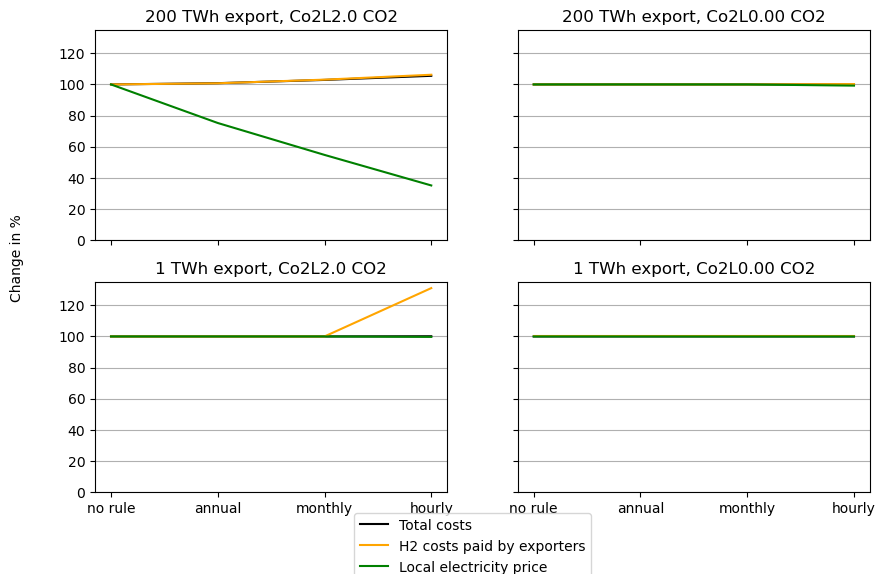

In [166]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

n=1
for h2export in h2exports:
    for o in opts:
        ax = plt.subplot(2, 2, n)
        n += 1

        df = prepare_data(ghrules, h2export, o)

        ax.plot(df.index, df["cost_rel"], label="Total costs", color="black")
        ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters", color="orange")
        ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price", color="green")

        ax.set_title(f"{h2export} TWh export, {o} CO2")
        ax.grid(axis='y')
        ax.set_ylim(0, 135)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.4,-0.01))
fig.text(0.04, 0.5, 'Change in %', va='center', rotation='vertical')

fig.savefig(OUTPUT+"subplot.pdf", bbox_inches="tight")
fig.show()

### Get realistic scenarios

In [167]:
def get_realistic_scenarios(h2exports, opts, upper_band, lower_band):

    h2exports = h2exports[::-1]
    # Creating a DataFrame with the specified index and columns
    df = pd.DataFrame(index=h2exports, columns=opts)

    # Filling the DataFrame with the combination of both arrays
    for row_label in h2exports:
        for col_label in opts:
            df.at[row_label, col_label] = f'{row_label}-{col_label}'
            df.at[row_label, col_label] = [row_label, col_label]

    realistic_scenarios = []
    for offset in range(lower_band, upper_band + 1):
        diagonal_values = np.diagonal(df.values[::-1], offset=offset)
        realistic_scenarios.extend(diagonal_values)

    return realistic_scenarios

In [168]:
def isin_realistic_scenario(h2export, opt, realistic_scenarios):

    # Combination of two values to check
    value_to_check = [h2export, opt]

    # Check if the combination is in the array
    combination_exists = any(all(x == y for x, y in zip(value_to_check, sublist)) for sublist in realistic_scenarios)

    return combination_exists

### Relative, multiple in one

In [169]:
h2exports = [1, 20 , 40, 60, 80, 100, 120, 140, 160, 180, 200]
#opts = ["Co2L2.0"]
opts = ["Co2L2.0", "Co2L0.90", "Co2L0.80", "Co2L0.70", "Co2L0.60", "Co2L0.50", "Co2L0.40", "Co2L0.30", "Co2L0.20", "Co2L0.10", "Co2L0.00"]
ghrules = ["no rule","annual", "monthly", "hourly"]
lower_band = -1 # Allow more towards h2export, negative
upper_band = 1 # Allow more towards decarbonisation, positive

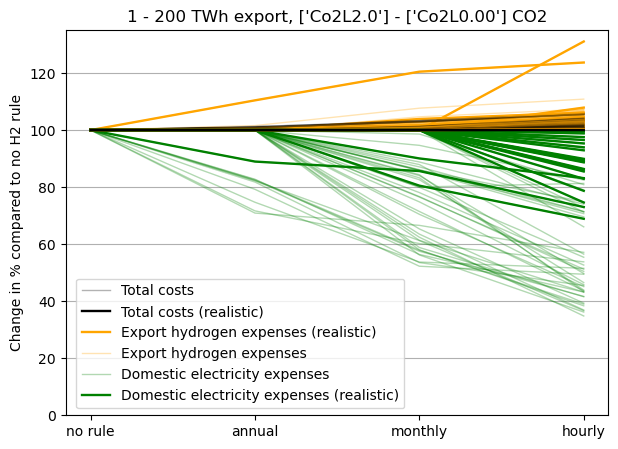

In [170]:
fig, ax = plt.subplots(figsize=(7, 5))

realistic_scenarios = get_realistic_scenarios(h2exports, opts, upper_band, lower_band)

for h2export in h2exports:
    for o in opts:

        df = prepare_data(ghrules, h2export, o)

        # # Relative prices
        # ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters", color="orange", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
        # ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price", color="green", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
        # ax.plot(df.index, df["cost_rel"], label="Total costs", color="black", linewidth=1, alpha=0.3)

        # if isin_realistic_scenario(h2export, o, realistic_scenarios):
        #     ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters (realistic)", color="orange", linewidth=1.7,  alpha=1)
        #     ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price (realistic)", color="green", linewidth=1.7, alpha=1)
        #     ax.plot(df.index, df["cost_rel"], label="Total costs (realistic)", color="black", linewidth=1.7, alpha=1)

        

        # Relative expenses
        df_rel = df / df.loc["no rule"] * 100
        ax.plot(df.index, df_rel["exp_H2_False_False_exportonly"], label="Export hydrogen expenses", color="orange", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
        ax.plot(df.index, df_rel["exp_AC_exclu_H2"], label="Domestic electricity expenses", color="green", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
        ax.plot(df.index, df_rel["cost_rel"], label="Total costs", color="black", linewidth=1, alpha=0.3)

        if isin_realistic_scenario(h2export, o, realistic_scenarios):
            ax.plot(df.index, df_rel["exp_H2_False_False_exportonly"], label="Export hydrogen expenses (realistic)", color="orange", linewidth=1.7,  alpha=1)
            ax.plot(df.index, df_rel["exp_AC_exclu_H2"], label="Domestic electricity expenses (realistic)", color="green", linewidth=1.7, alpha=1)
            ax.plot(df.index, df_rel["cost_rel"], label="Total costs (realistic)", color="black", linewidth=1.7, alpha=1)


ax.set_title(f"{min(h2exports)} - {max(h2exports)} TWh export, {opts[:1]} - {opts[-1:]} CO2")
ax.grid(axis='y')
ax.set_ylim(0, 135)

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))  # Get unique labels
unique_handles = [handles[labels.index(label)] for label in unique_labels]  # Get corresponding handles

#fig.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.55, 0.5))
fig.legend(unique_handles, unique_labels, loc='lower left', bbox_to_anchor=(0.13, 0.11))

ax.set_ylabel("Change in % compared to no H2 rule")

fig.savefig(OUTPUT+"rel_multiple.pdf", bbox_inches="tight")

plt.show()

### Relative, single

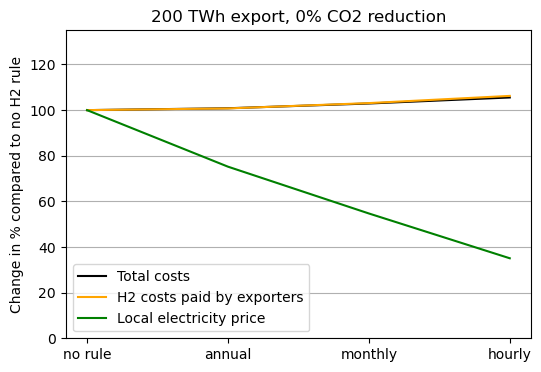

In [171]:
df = prepare_data(ghrules, 200, "Co2L2.0")
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df.index, df["cost_rel"], label="Total costs", color="black")
ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters", color="orange")
ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price", color="green")

#ax.set_xlabel("H2 rule")
ax.set_ylabel("Change in % compared to no H2 rule")
ax.set_title(f"200 TWh export, 0% CO2 reduction")
ax.set_ylim(0, 135)
ax.grid(axis='y')

ax.legend(loc="lower left")

### Absolute prices

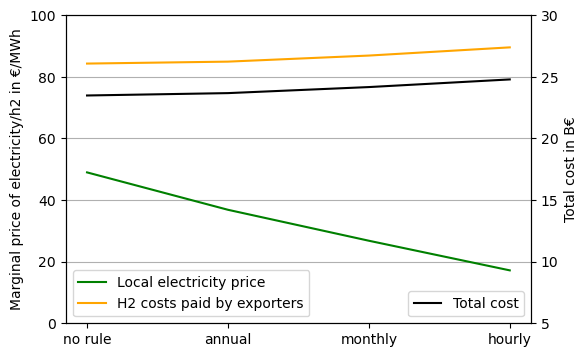

In [172]:
df = prepare_data(ghrules, 200, "Co2L2.0")
fig, ax = plt.subplots(figsize=(6, 4))

#ax.plot(df.index, df["cost"]/1e9, label="Total cost")
ax.plot(df.index, df["mg_AC_exclu_H2"], label="Local electricity price", color="green")
ax.plot(df.index, df["mg_H2_False_False_exportonly"], label="H2 costs paid by exporters", color="orange")


# Add secondary axis for total cost
ax2 = ax.twinx()
ax2.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")
ax2.set_ylabel("Total cost in B€")
ax2.set_ylim(5, 30)

#ax.set_xlabel("H2 rule")
ax.set_ylabel("Marginal price of electricity/h2 in €/MWh")
ax.set_ylim(0, 100)

ax.legend(loc="lower left")
ax2.legend(loc="lower right")

ax.grid(axis='y')

### Absolute expenses

In [173]:
h2export = 200
opts = "Co2L2.0"

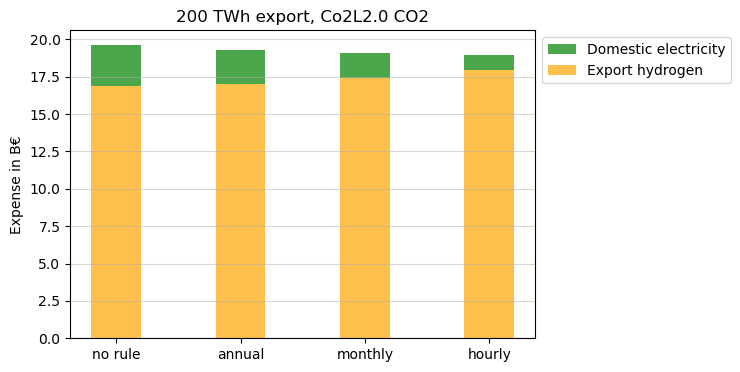

In [174]:
df = prepare_data(ghrules, h2export, opts)
fig, ax = plt.subplots(figsize=(6, 4))

width = 0.4
ax.bar(df.index, df["exp_H2_False_False_exportonly"]/1e3, width=width, label="Export hydrogen", color="orange", alpha=0.7)
ax.bar(df.index, df["exp_AC_exclu_H2"]/1e3, bottom=df["exp_H2_False_False_exportonly"]/1e3, width=width, label="Domestic electricity", color="green", alpha=0.7)
#ax.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")

ax.set_ylabel("Expense in B€")
#ax.set_ylim(0, 27)

#ax.set_xlabel("H2 rule")
ax.set_title(f"{h2export} TWh export, {opts} CO2")

# Reverse legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))

ax.grid(axis='y', alpha=0.5)   

fig.savefig(OUTPUT+f"abs_sin_expenses_h2ac_{h2export}_{opts}.pdf", bbox_inches="tight")

### All average nodal prices

In [175]:
def get_mean_prices(stats, h2export, opts):
    """Filter stats according to h2export value and opts value
    """
    stats = stats[(stats.index == h2export) & (stats.opts == opts)]
    stats = stats.iloc[:, stats.columns.str.startswith("mean_mg")]

    return stats

In [176]:
def prepare_mean_prices(ghrules, h2export, opts):
    df = pd.DataFrame() #index=ghrules)

    for rule in ghrules:
        INPUT = PREFIX + "results/" + RUNS[rule] + "/integrated_comp/stats.csv"
        stats = pd.read_csv(INPUT, index_col=0)
        prices = get_mean_prices(stats, h2export, opts)    
        prices.index = [rule]
        df = pd.concat([df, prices])

    return df  

In [177]:
h2export = 200
opts = "Co2L2.0"
increase = 0.04 # Percentage of increase above which it is considered as increase. Set "False" to allow all marginal prices

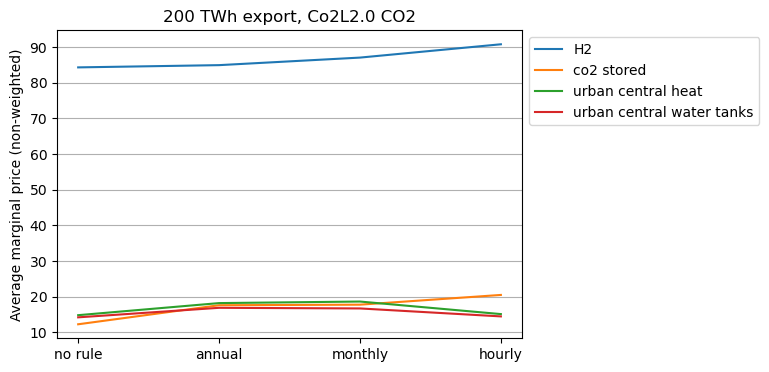

In [178]:
df = prepare_mean_prices(ghrules, h2export, opts)

if increase != False:
    # Filter df for columns which have higher values in any row (apart from "no rule") than in "no rule"
    df = df.loc[:, (df.loc[["hourly", "monthly", "annual"]] > (df.loc["no rule"]*(1+increase/100))).any()]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df.index, df, label=df.columns.str.replace("mean_mg_", ''))

#ax.set_xlabel("H2 rule")
ax.set_ylabel("Average marginal price (non-weighted)")
ax.set_title(f"{h2export} TWh export, {opts} CO2")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.grid(axis='y')

### System cost by expense

In [179]:
h2export = 1
opts = "Co2L0.00"

In [180]:
EXPORT = h2export
CO2L = 0.00
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.13

RUN = "decr_13_3h_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"

In [181]:
n = pypsa.Network(INPUT)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [182]:
# TODO simplify this. df.loc["no rule"] is the same as -(n.statistics.revenue(comps=["Load"]) /1e9).droplevel(0)

In [183]:
n.objective / 1e9

15.86059281156479

In [184]:
def get_expense_carrier(n, excl_em=True):

    # Multiply demands and prices
    loads = n.loads_t.p[n.loads.index]
    loads.columns = n.loads.bus # Rename columns to bus names to comply with columns of "prices"
    prices = n.buses_t.marginal_price[n.loads.bus]
    expenses = loads * prices * n.snapshot_weightings.generators[0]

    nodal_expense = expenses.sum() #.groupby(n.loads.bus).sum() / 1e9
    nodal_expense.name = "expense"

    # concat loads_carrier and nodal_expense based on index
    loads_carrier = n.loads.carrier
    loads_carrier.index = n.loads.bus 
    nodal_expense_m = pd.concat([nodal_expense, loads_carrier], axis=1)

    expense_c = nodal_expense_m.groupby("carrier").sum() / 1e9

    if excl_em == True:
        expense_c = expense_c[~expense_c.index.str.contains("emission")]
    else:
        pass

    # # Alternative calc method
    # expenses = n.statistics.revenue() #[n.statistics.revenue() < 0]
    # expenses = expenses.droplevel(0)
    # expense_c = pd.DataFrame(expenses / 1e9)

    return expense_c

In [185]:
def get_expense_carriers(ghrules, h2export, opts, excl_em):
    """Get expense per carrier
    """

    df = pd.DataFrame()

    for rule in ghrules:
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        expense_c = get_expense_carrier(n, excl_em=excl_em)
        expense_c = expense_c.T
        expense_c.index = [rule]
        expense_c.columns.name = None

        df = pd.concat([df, expense_c])

        
    return df

In [186]:
def prep_expense_carriers(df):
   # Combine the columns containing "AC" or "electricity" to one col and delete the others
   combine_cols = df.columns[df.columns.str.contains("electricity")]
   ev = "land transport EV"

   if ev in df.columns:
      df["Local electricity"] =  df[combine_cols].sum(axis=1) + df["AC"] + df["land transport EV"]
      df = df.drop(columns=["AC", "land transport EV"])
   else:
      df["Local electricity"] =  df[combine_cols].sum(axis=1) + df["AC"]
      df = df.drop(columns=["AC"])
   
   df = df.drop(columns=combine_cols)

   move = ["H2", "Local electricity"]
   keep = df.columns[~df.columns.isin(move)]
   df = df[move + list(keep)]

   return df

In [187]:
df = get_expense_carriers(ghrules, h2export, opts, excl_em=True)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [188]:
df_plot = prep_expense_carriers(df)

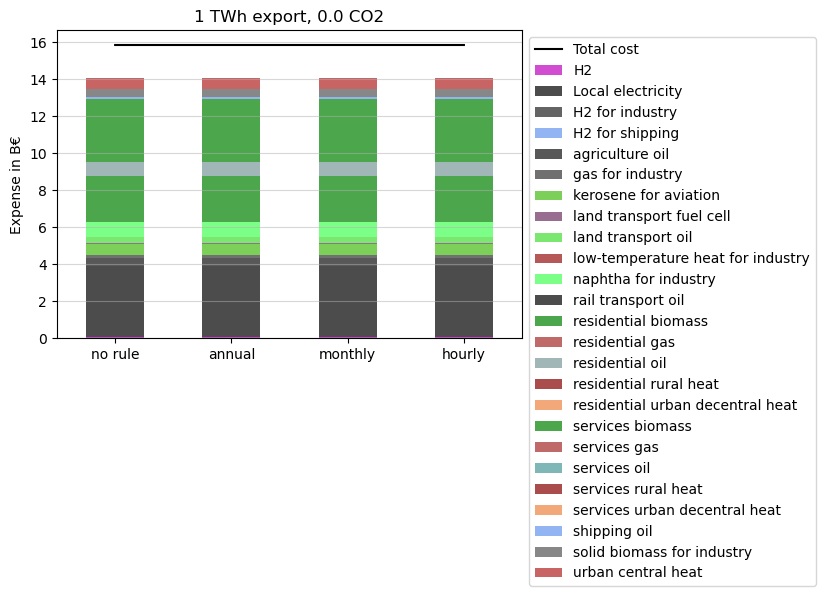

In [189]:
fig, ax = plt.subplots(figsize=(6, 4))

df_cost = prepare_data(ghrules, h2export, opts)
config = load_config(config_aldehyde)
colors = config["plot"]["tech_colors"]

plt.plot(df.index, df_cost["cost"]/1e9, label="Total cost", color="black")
df_plot.plot.bar(ax=ax, stacked=True, alpha=0.7, color=colors)

#plt.xlabel("H2 rule")
plt.ylabel("Expense in B€")
plt.title(f"{h2export} TWh export, {CO2L} CO2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.5) 
plt.xticks(rotation=0)

fig.savefig(OUTPUT+f"abs_sin_expenses_{h2export}_{opts}.pdf", bbox_inches="tight")

### System costs by technology

In [190]:
# Theory: total system cost = n.objective
(n.statistics.capex().sum() - n.statistics.installed_capex().sum()) - (n.statistics.capex() - n.statistics.installed_capex()).sum()

-1.9073486328125e-06

In [191]:
def get_costs(threshold, ghrules, h2export, opts):
    """Get costs
    """

    costs = pd.DataFrame()

    for rule in ghrules:
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        # Prepare CAPEX
        capex = n.statistics.capex() - n.statistics.installed_capex()
        threshold_sum_capex = capex[capex < threshold].sum() / 1e9
        capex = capex[capex > threshold] / 1e9 # in B€
        capex = pd.DataFrame(capex.droplevel(0)).T
        capex = capex.add_suffix(" (CAPEX)")
        capex[f"(CAPEX < {threshold/1e6} M€ thres.)"] = threshold_sum_capex

        # Rename H2 to H2 Storage
        capex = capex.rename(columns={"H2 (CAPEX)": "H2 Storage (CAPEX)"})

        # Prepare OPEX
        opex = n.statistics.opex()
        threshold_sum_opex = opex[opex < threshold].sum() / 1e9
        opex = opex[opex > threshold] / 1e9
        opex = pd.DataFrame(opex.droplevel(0)).T
        opex = opex.add_suffix(" (OPEX)")
        opex[f"(OPEX < {threshold/1e6} M€ thres.)"] = threshold_sum_opex
        opex =opex.groupby(opex.columns, axis=1).sum()

        # Combine CAPEX and OPEX
        caop = pd.concat([capex, opex], axis=1)
        caop.index = [rule]

        # Add to costs df
        costs = pd.concat([costs, caop], axis=0) #, ignore_index=True)

    
    return costs

In [192]:
threshold = 100e6 # 10 M€

In [193]:
costs = get_costs(threshold, ghrules, h2export, opts)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


KeyError: 'process emissions CC (CAPEX)'

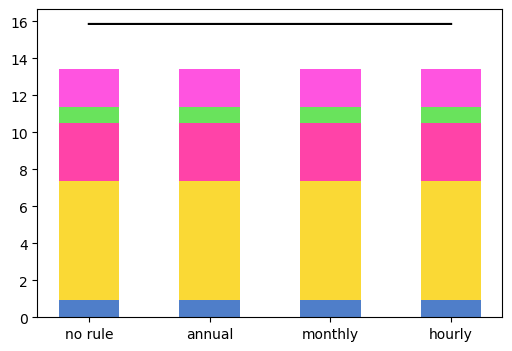

In [194]:
df = prepare_data(ghrules, h2export, opts)

fig, ax = plt.subplots(figsize=(6, 4))

colors = config["plot"]["tech_colors"]
plt.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")
costs.plot.bar(ax=ax, stacked=True, alpha=0.8, color=colors)


#plt.xlabel("H2 rule")
plt.ylabel("Costs in B€")
plt.title(f"{h2export} TWh export, {CO2L} CO2")
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

plt.grid(axis='y', alpha=0.5) 

fig.savefig(OUTPUT+f"abs_sin_tech_{h2export}_{opts}.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

# Divide all values by first row
costs_rel = costs / costs.iloc[0] *100

costs_rel.plot.line(ax=ax, alpha=0.7)
#plt.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")

# plt.xlabel("H2 rule")
plt.ylabel("Relative change in %")
plt.title(f"{h2export} TWh export, {CO2L} CO2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.5) 

### Dispatch

In [195]:
threshold_dispatch = 1e6 # 4 TWh
h2export = 200
opts = "Co2L2.0"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_DF_{h2export}export"


In [196]:
def get_dispatch(threshold_dispatch, ghrules, h2export, opts, show_demand=True):
    """Get dispatch
    """

    dispatch_all = pd.DataFrame()

    for rule in ghrules:
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        dispatch = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") > 0]
        threshold_dispatch_sum = dispatch[dispatch < threshold_dispatch].sum()
        dispatch = dispatch[dispatch > threshold_dispatch]
        dispatch = pd.DataFrame(dispatch.droplevel(0)).T
        dispatch[f"(Dispatch < {threshold_dispatch/1e6} TWh thres.)"] = threshold_dispatch_sum

        dispatch.index = [rule]

        dispatch_all = pd.concat([dispatch_all, dispatch], axis=0) #, ignore_index=True)

    if show_demand == "bar":
        dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
        total_demand = dispatch_demand.sum() * (-1)
        other_demand = total_demand - ely_electricity
        dispatch_all.loc["Demand", "H2 Electrolysis electricity"] = ely_electricity
        dispatch_all.loc["Demand", "Domestic electricity"] = other_demand
        
    elif show_demand == "line":
        dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
        total_demand = dispatch_demand.sum() * (-1)
        other_demand = total_demand - ely_electricity
        dispatch_all.loc[:, "H2 Electrolysis electricity"] = ely_electricity
        dispatch_all.loc[:, "Domestic electricity"] = other_demand
        
    
    return dispatch_all

In [197]:
dispatch = get_dispatch(threshold_dispatch, ghrules, h2export, opts, show_demand="bar")

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


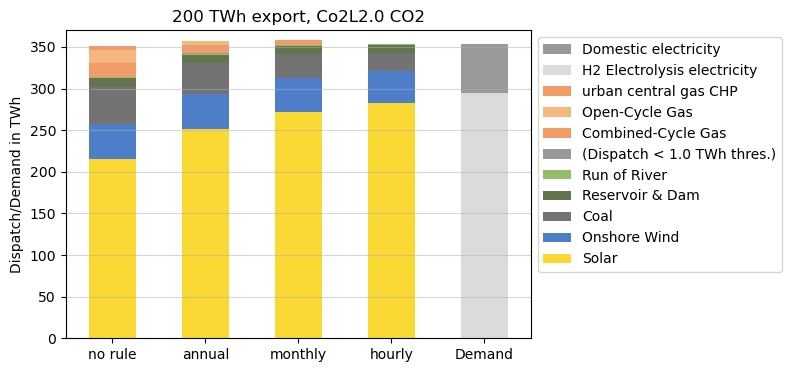

In [198]:
df = prepare_data(ghrules, h2export, opts)

fig, ax = plt.subplots(figsize=(6, 4))

colors = config["plot"]["tech_colors"]
# Sort columns by highest value in first row
dispatch_sorted = dispatch[dispatch.iloc[3].sort_values(ascending=False).index]
dispatch_twh = dispatch_sorted / 1e6 # in TWh

# This line in case of electricty line not bar
# dispatch_twh = dispatch_twh.iloc[:, ~dispatch_twh.columns.isin(["H2 Electrolysis electricity", "Domestic electricity"])]
# dispatch[["H2 Electrolysis electricity", "Domestic electricity"]].div(1e6).plot.line(ax=ax, alpha=1, color=colors)

dispatch_twh.plot.bar(ax=ax, stacked=True, alpha=0.8, color=colors)

#plt.xlabel("H2 rule")
plt.ylabel("Dispatch/Demand in TWh")
plt.title(f"{h2export} TWh export, {opts} CO2")
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.ylim(0, 370)

plt.grid(axis='y', alpha=0.5) 

fig.savefig(OUTPUT+f"dispatch_{h2export}_{opts}.pdf", bbox_inches="tight")

### n.statistics() tests

CAPEX and OPEX: works

In [ ]:
n.objective / 1e9 - (n.statistics.capex().sum() + n.statistics.opex().sum() - n.statistics.installed_capex().sum() )/ 1e9

In [ ]:
n.objective / 1e9

In [ ]:
n.statistics.capex().sum() / 1e9

In [ ]:
n.statistics.opex().sum() / 1e9

In [ ]:
n.statistics.installed_capex().sum() / 1e9

In [ ]:
n.statistics.opex().sort_values() / 1e9

Revenue

In [ ]:
# Expenses
n.statistics.revenue()[n.statistics.revenue() <0].sum() / 1e9

In [ ]:
# Incomes
n.statistics.revenue()[n.statistics.revenue() >0].sum() / 1e9

In [ ]:
n.statistics.revenue()[n.statistics.revenue() >0].sort_values() / 1e9

In [ ]:
# n.statistics.revenue(comps=["Load"]).droplevel(0).div(1e9).plot.bar(
#     title="Revenue from load",
# )

In [ ]:
n.statistics.revenue(comps=["Load"]).sort_values() / 1e9

In [ ]:
n.statistics.revenue(comps=["Load"])[n.statistics.revenue(comps=["Load"]).droplevel(0).index.str.contains("oil")].sort_values().sum() / 1e9

In [ ]:
n.statistics.revenue(comps=["Store"]).sort_values()  / 1e9

In [ ]:
n.statistics.revenue(comps=["Store"])[n.statistics.revenue(comps=["Store"]) <0].sum() / 1e9

In [ ]:
n.statistics.revenue(comps=["Store"])[n.statistics.revenue(comps=["Store"]) >0].sum() / 1e9

Misc

In [ ]:
EXPORT = 200
CO2L = 2.0
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.13

RUN = "decr_13_3h_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_Co2L{CO2L}_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"

In [ ]:
n = pypsa.Network(INPUT)

In [ ]:
n.objective / 1e9

In [ ]:
# Who pays?
expenses = n.statistics.revenue()[n.statistics.revenue() < 0]
expenses = expenses.droplevel(0)

In [ ]:
# Filter out "emissions" from expenses
expenses_wo_em = expenses[~expenses.index.str.contains("emission")]

In [ ]:
expenses[expenses.index.str.contains("emission")] / 1e9

In [ ]:
expenses.sum() / 1e9

In [ ]:
expenses_wo_em.sum() / 1e9

In [ ]:
expenses_wo_em.sum() / 1e9 + n.objective / 1e9

In [ ]:
# Who earns?
expenses = n.statistics.revenue()[n.statistics.revenue() > 0]
expenses = expenses.droplevel(0)
(expenses / 1e9).sort_values(ascending=False)